数据集形状: (1757, 26)
缺失值统计:
Environment        1757
Unnamed: 24        1757
Trans Mode         1757
Grade              1757
Crop               1757
Storage            1757
Appearance         1757
Condition          1757
Quality            1757
Type               1712
Unnamed: 25        1654
Origin District    1626
Unit of Sale       1595
Sub Variety        1461
Color               616
Item Size           279
Mostly High         103
Mostly Low          103
Variety               5
Origin                3
High Price            0
Low Price             0
Date                  0
Repack                0
Package               0
City Name             0
dtype: int64


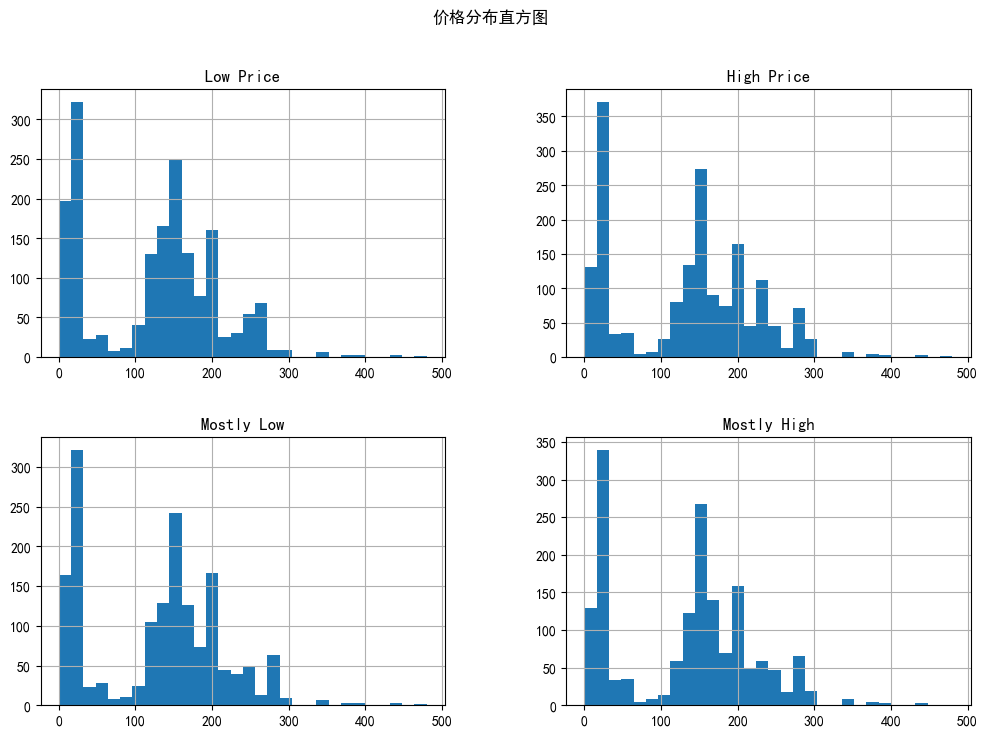

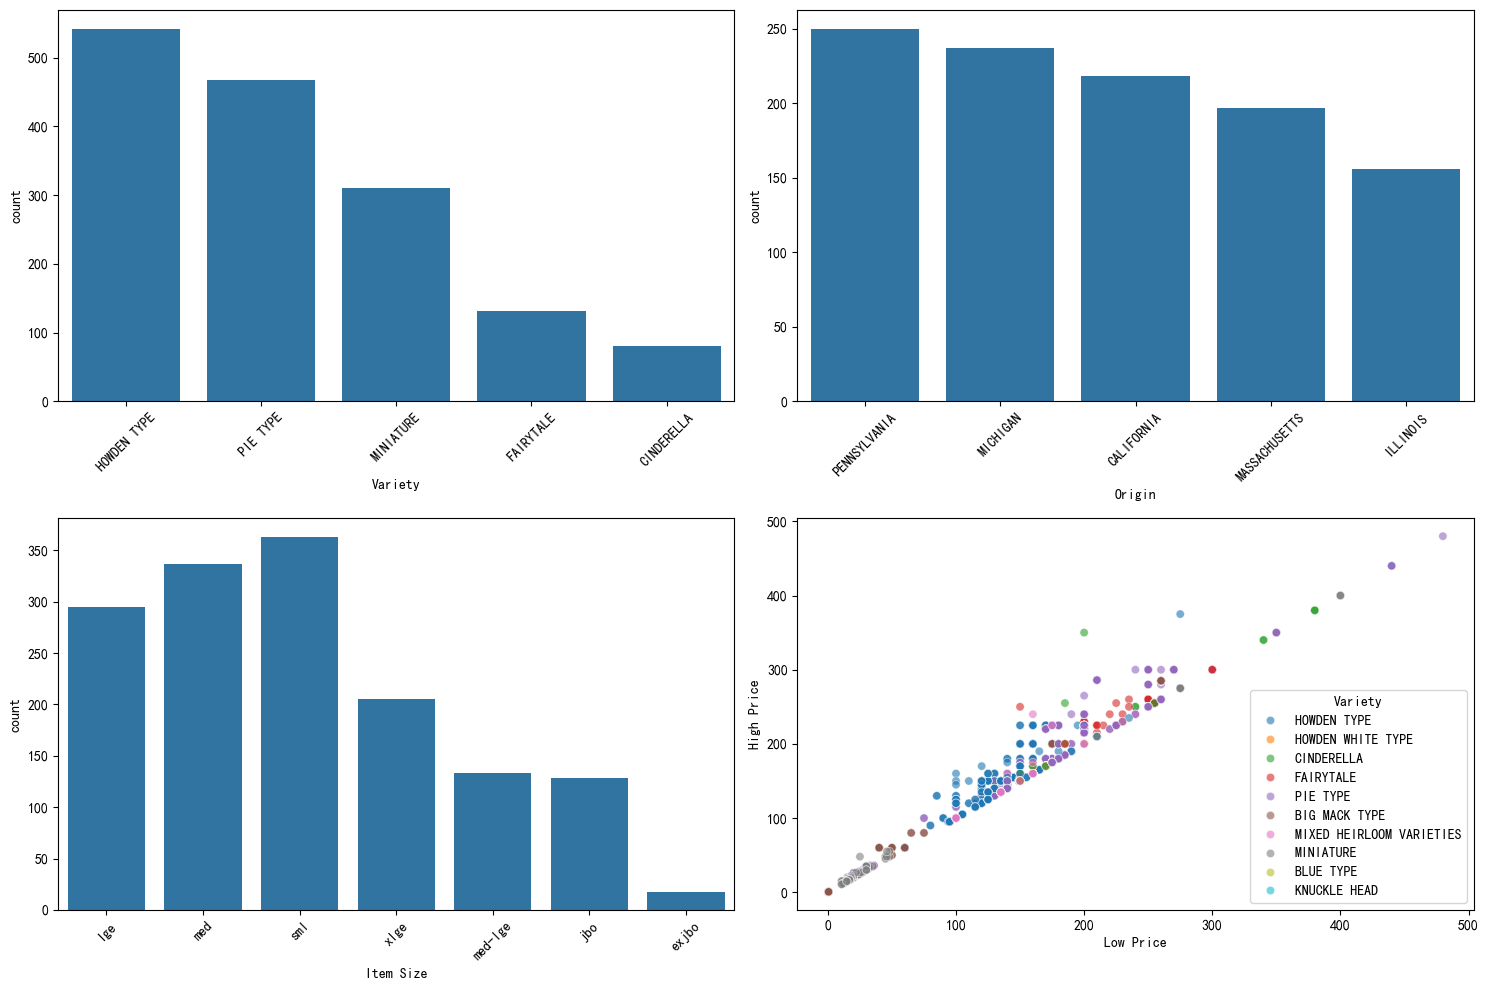

C:\Users\86182\AppData\Local\Temp\ipykernel_23156\2425704121.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


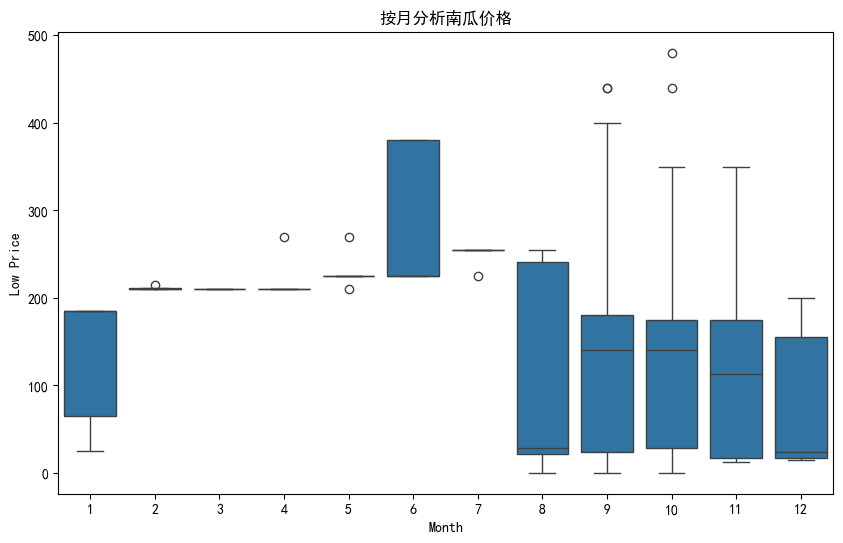

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# 加载数据
df = pd.read_csv('US-pumpkins.csv')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 基础信息
print(f"数据集形状: {df.shape}")
print(f"缺失值统计:\n{df.isnull().sum().sort_values(ascending=False)}")

# 价格分布分析
price_cols = ['Low Price', 'High Price', 'Mostly Low', 'Mostly High']
df[price_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle('价格分布直方图')
plt.show()

# 关键特征分布
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(data=df, x='Variety', ax=ax[0][0], order=df['Variety'].value_counts().iloc[:5].index)
ax[0][0].tick_params(axis='x', rotation=45)
sns.countplot(data=df, x='Origin', ax=ax[0][1], order=df['Origin'].value_counts().iloc[:5].index)
ax[0][1].tick_params(axis='x', rotation=45)
sns.countplot(data=df, x='Item Size', ax=ax[1][0])
ax[1][0].tick_params(axis='x', rotation=45)
sns.scatterplot(data=df, x='Low Price', y='High Price', hue='Variety', alpha=0.6, ax=ax[1][1])
plt.tight_layout()
plt.show()

# 日期转换和按月分析
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Month', y='Low Price')
plt.title('按月分析南瓜价格')
plt.show()

In [29]:
#  数据预处理
# 目标变量创建
df['Avg_Price'] = (df['Mostly Low'] + df['Mostly High']) / 2

# 关键特征选择
features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
df = df[features + ['Date', 'Avg_Price']].copy()

# 日期特征工程
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# 缺失值处理
df['Color'].fillna('UNKNOWN', inplace=True)
df['Item Size'].fillna('MEDIUM', inplace=True)  # 基于业务假设
df['Unit of Sale'].fillna('BIN', inplace=True)  # 主要销售单位

# 异常值处理
Q1 = df['Avg_Price'].quantile(0.25)
Q3 = df['Avg_Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Avg_Price'] < (Q1 - 1.5 * IQR)) | (df['Avg_Price'] > (Q3 + 1.5 * IQR)))]

C:\Users\86182\AppData\Local\Temp\ipykernel_23156\697264252.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Color'].fillna('UNKNOWN', inplace=True)
C:\Users\86182\AppData\Local\Temp\ipykernel_23156\697264252.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [31]:
# 特征编码和标准化
categorical_features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
numerical_features = ['Month', 'Week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 创建管道
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [32]:
# 检查目标变量中的缺失值
print(f"目标变量中缺失值的数量: {y.isnull().sum()}")

# 删除目标变量中包含缺失值的行
df = df.dropna(subset=['Avg_Price'])

# 重新定义X和y
X = df.drop(columns=['Avg_Price'])
y = df['Avg_Price']

目标变量中缺失值的数量: 0


In [33]:
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型训练
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Month', 'Week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['City Name', 'Package',
                                                   'Variety', 'Origin',
                                                   'Item Size', 'Color',
                                                   'Unit of Sale'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Mean Squared Error: 243.7306369850457
R² Score: 0.9673276872773613


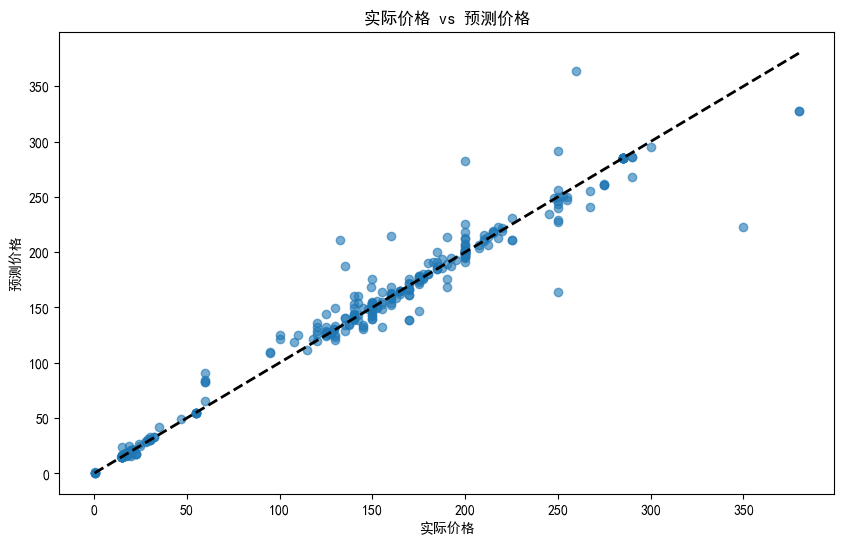

In [34]:
# 模型预测
y_pred = model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')
# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('实际价格')
plt.ylabel('预测价格')
plt.title('实际价格 vs 预测价格')
plt.show()

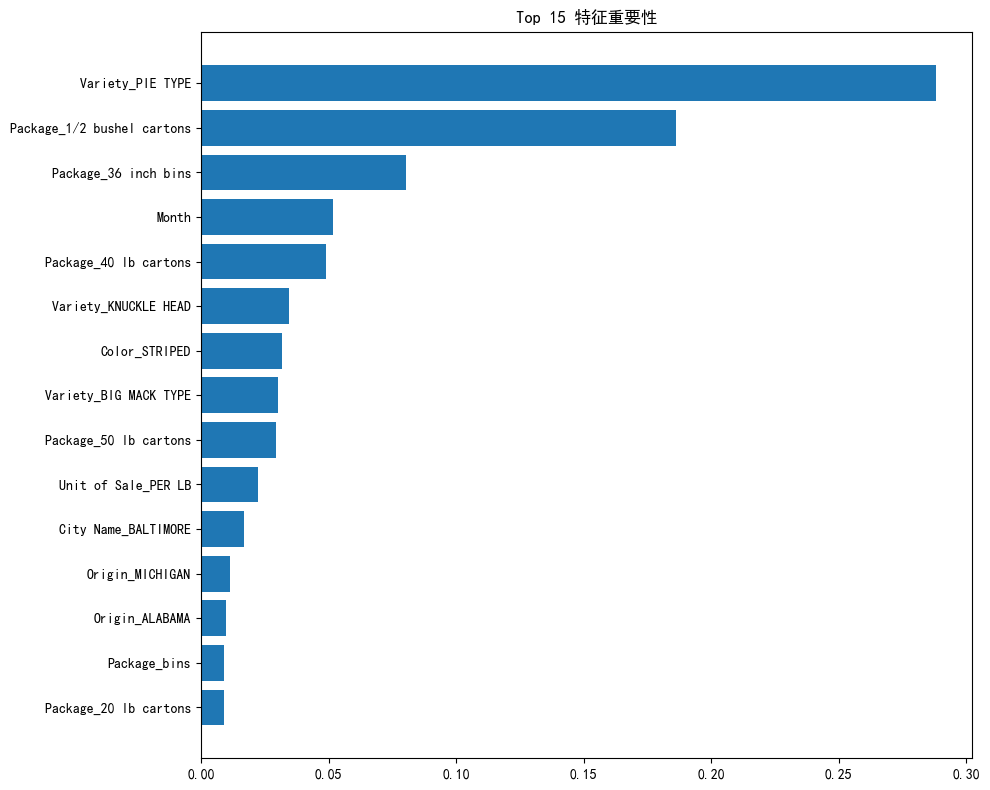

In [39]:
# 特征重要性可视化
feature_names = (model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features))

feature_names = np.concatenate([feature_names, numerical_features])

importances = model.named_steps['regressor'].feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx[-15:])), importances[sorted_idx[-15:]])
plt.yticks(range(len(sorted_idx[-15:])), feature_names[sorted_idx[-15:]])
plt.title("Top 15 特征重要性")
plt.tight_layout()
plt.show()

In [40]:
# 查看模型的系数
coefficients = model.named_steps['regressor'].feature_importances_
feature_names = np.array(numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out()))
sorted_idx = np.argsort(coefficients)[::-1]

print("特征重要性：")
for i in sorted_idx:
    print(f"{feature_names[i]}: {coefficients[i]}")

特征重要性：
Variety_MINIATURE: 0.2879662172396784
Package_1 1/9 bushel cartons: 0.18623517591040348
Package_24 inch bins: 0.08024095269956019
Unit of Sale_PER LB: 0.05169736419920589
Package_35 lb cartons: 0.04902882423167146
Variety_HOWDEN TYPE: 0.03446412635661045
Item Size_xlge: 0.03167193550378004
Package_bushel cartons: 0.0300991084591869
Package_36 inch bins: 0.029378875708954578
Unit of Sale_EACH: 0.022344413264741382
Week: 0.01693244203199429
Origin_MASSACHUSETTS: 0.01119549947532581
Variety_PIE TYPE: 0.009945938272243354
Package_50 lb cartons: 0.009033136055857595
Package_1 1/9 bushel crates: 0.008976714106889995
Package_1/2 bushel cartons: 0.007855296451498392
Month: 0.00645655835848866
Item Size_sml: 0.006158606777847757
City Name_SAN FRANCISCO: 0.005996304493086378
Origin_CALIFORNIA: 0.005921103531760785
Variety_BIG MACK TYPE: 0.0057333288964850695
Package_50 lb sacks: 0.00546240668345158
City Name_LOS ANGELES: 0.00526147270620467
Unit of Sale_BIN: 0.005136135230422699
Item Size

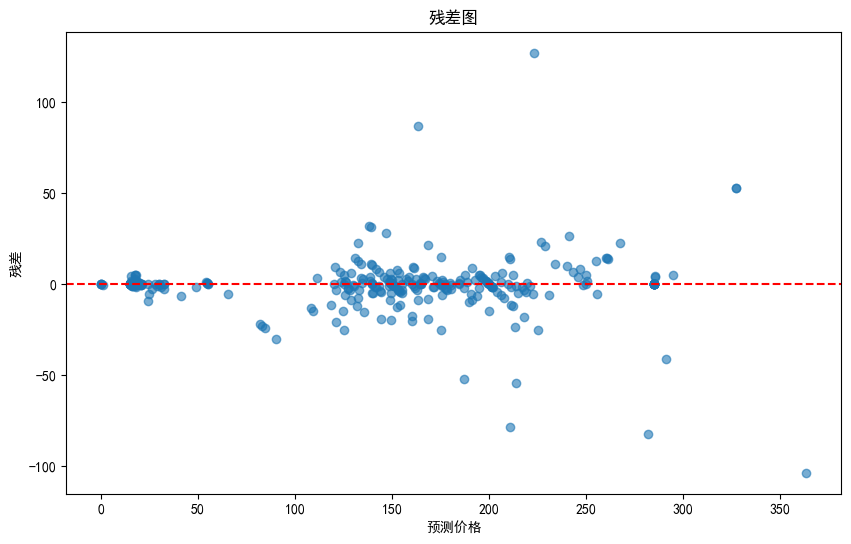

In [41]:
# 残差分析
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测价格')
plt.ylabel('残差')
plt.title('残差图')
plt.show()
